In [17]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from typing import List, Tuple, Union
import numpy as np
from itertools import zip_longest
from copy import deepcopy
from collections import Counter
from torch_scatter import scatter_sum, scatter_mean
import logging
from rdkit import Chem
import math
from onmt.modules.embeddings import PositionalEncoding
from onmt.modules.position_ffn import PositionwiseFeedForward
from onmt.utils.misc import sequence_mask
import sys
sys.path.append("/home/chenlidong/polyAttn/models")
sys.path.append("/home/chenlidong/polyAttn/utils")
# import polygnn
sys.path.append("/home/chenlidong/polymer-chemprop-master/chemprop/")
import chem_utils
import pdb
from torch.nn.utils.rnn import pad_sequence
from typing import List, Union, Tuple
from functools import reduce
from rdkit import Chem
import torch.nn.init as init
import networkx as nx

In [18]:
from args import TrainArgs
from features import mol2graph, BatchMolGraph, get_atom_fdim, get_bond_fdim
from nn_utils import get_activation_function, index_select_ND

# polygnn测试代码

In [2]:
hps ={
    "capacity" : 2,
    "activation": nn.functional.leaky_relu,
    "readout_dim": 128
}
model = polygnn.polygnn(32,7,True,hps)

In [3]:
node_features, edge_features, edge_indices = chem_utils.get_feature("[*]Oc1ccc(-c2ccc(C([*])=O)cc2)cc1")

In [4]:
data = Data(
    x = torch.tensor(node_features, dtype=torch.float),
    edge_index = torch.tensor(edge_indices, dtype=torch.long).T,
    edge_weight = torch.tensor(edge_features, dtype=torch.float),
)

In [5]:
train_loader = DataLoader(
            dataset=[data],
            batch_size=1,
            shuffle=True,
            pin_memory=True
        )

In [8]:
for batch_idx, batch in enumerate(train_loader):
    print(model(batch))

tensor([[0.4337, 0.3888, 0.3650, 0.3436, 0.3988, 0.3499, 0.3956, 0.4133, 0.3567,
         0.4352, 0.3738, 0.3076, 0.3832, 0.3693, 0.4158, 0.4409, 0.4127, 0.4084,
         0.4287, 0.4251, 0.3337, 0.4168, 0.4429, 0.3431, 0.4172, 0.3630, 0.4217,
         0.4064, 0.3803, 0.3957, 0.4111, 0.3503, 0.4047, 0.4475, 0.3495, 0.3449,
         0.3784, 0.3999, 0.3801, 0.3518, 0.4274, 0.3092, 0.3732, 0.3583, 0.3823,
         0.3584, 0.4099, 0.4279, 0.3385, 0.3373, 0.4120, 0.3693, 0.3263, 0.4335,
         0.3913, 0.4095, 0.3489, 0.3001, 0.4066, 0.3830, 0.3599, 0.3715, 0.4065,
         0.4032, 0.3953, 0.4147, 0.3725, 0.4038, 0.3840, 0.4478, 0.3282, 0.3981,
         0.3390, 0.3768, 0.4021, 0.4305, 0.4000, 0.3825, 0.3874, 0.4016, 0.3292,
         0.3710, 0.3279, 0.4633, 0.3882, 0.3455, 0.4211, 0.4184, 0.3750, 0.3709,
         0.3644, 0.3426, 0.4080, 0.4180, 0.3483, 0.3365, 0.3140, 0.2962, 0.3640,
         0.4033, 0.3791, 0.4103, 0.4069, 0.4254, 0.3285, 0.3350, 0.2872, 0.3729,
         0.3825, 0.3926, 0.3

# polymer-chemprob

In [29]:
smiles = "OB(O)c1cc2ccc3cc(B(O)O)cc4ccc(c1)c2c34.CC(=O)Nc1cc(Br)cc(Br)c1"
smiles0 = "OB(O)c1ccc(-c2ccc(B(O)O)s2)s1.Cn1cc(Br)nc1Br"
smiles1 = "*Oc1ccc(cc1)c1ccc(cc1)C(=O)OCC(COC(=O)c1ccc(cc1)c1ccc(cc1)OC(CC*)C)C"
smiles2 = "*OS(=O)(=O)c1ccc(cc1)*"

In [32]:
batch_mol2graph = mol2graph([smiles,smiles0,smiles1,smiles2],[0,1,2,0],[0,1,2,0])
f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _ ,distance, idx = batch_mol2graph.get_components()

In [5]:
a_scope

[(1, 25), (26, 25), (51, 25), (76, 26)]

In [17]:
b_scope

[(1, 48), (49, 48), (97, 48), (145, 34)]

In [6]:
distance[0] 

tensor([[  0,   1,   2,  ..., 100, 100, 100],
        [  1,   0,   1,  ..., 100, 100, 100],
        [  2,   1,   0,  ..., 100, 100, 100],
        ...,
        [100, 100, 100,  ..., 100, 100, 100],
        [100, 100, 100,  ..., 100, 100, 100],
        [100, 100, 100,  ..., 100, 100, 100]])

In [13]:
distance[3][3]

tensor([ 3,  2,  1,  0,  1,  2,  2,  3, 10, 10, 10, 10, 10, 10, 10, 10, 10, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [9]:
distance.shape

torch.Size([4, 45, 45])

In [20]:
a2a = batch_mol2graph.get_a2a()
b2b = batch_mol2graph.get_b2b()
# ea = torch.tensor(valid_df.Ea.to_list(),dtype=torch.float32)
# ip = torch.tensor(valid_df.IP.to_list(),dtype=torch.float32)

In [15]:
def get_distance(edge_index,w_bonds,atom_num,max_len=45,max_distance=20):
    G = nx.MultiDiGraph()
    edge_index = edge_index.t().tolist()
    weights = torch.reciprocal(w_bonds).tolist()
    for i in range(0,atom_num):
        G.add_node(i)
    for i, (start_node, end_node) in enumerate(edge_index):
        weight = weights[i]
        G.add_edge(start_node, end_node,weight=weight)
    padded_distance = np.ones((max_len, max_len), dtype=np.int32) * max_distance
    padded_distance[:atom_num, :atom_num] = nx.floyd_warshall_numpy(G)
    return torch.tensor(padded_distance)

In [10]:
dataset = []

for idx,(a_scope_i,b_scope_i) in enumerate(zip(a_scope,b_scope)):
    edge_index = [[],[]]
    b2a_i = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    b2revb_i = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]

    for i in range(b2a_i.size(0)):
        edge_index[0].append(b2a_i[i].item()-a_scope_i[0])
        edge_index[1].append(b2a_i[b2revb_i[i]-b_scope_i[0]]-a_scope_i[0])
    
    edge_index = torch.tensor(edge_index,dtype=torch.long)
    w_atom = w_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]]
    w_bond = w_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    edge_attr = f_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    data = Data(
        x = f_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
        edge_index=edge_index,
        edge_attr = edge_attr,
        w_atoms = w_atom,
        w_bonds = w_bond,
        b2revb = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]-b_scope_i[0],
        distance = distance[idx]
    )
    dataset.append(data.to("cuda"))

In [42]:
dataset[0].edge_index

tensor([[ 0,  1,  0, 13,  1,  2,  2,  3,  2, 14,  3,  4,  4,  5,  5,  6,  5, 15,
          6,  7,  7,  8,  8,  9,  9, 10,  9, 15, 10, 11, 11, 12, 12, 13, 12, 14,
         14, 15, 16, 17, 16, 43, 17, 18, 17, 22, 18, 19, 19, 20, 20, 21, 21, 22,
         22, 23, 23, 24, 23, 38, 24, 25, 24, 37, 25, 26, 25, 30, 26, 27, 27, 28,
         28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 32, 37, 33, 34, 34, 35, 35, 36,
         36, 37, 38, 39, 38, 43, 39, 40, 40, 41, 41, 42, 42, 43,  0,  7,  0,  0,
          7,  7, 16, 31, 16, 16, 31, 31,  0, 16,  0, 31,  7, 16,  7, 31],
        [ 1,  0, 13,  0,  2,  1,  3,  2, 14,  2,  4,  3,  5,  4,  6,  5, 15,  5,
          7,  6,  8,  7,  9,  8, 10,  9, 15,  9, 11, 10, 12, 11, 13, 12, 14, 12,
         15, 14, 17, 16, 43, 16, 18, 17, 22, 17, 19, 18, 20, 19, 21, 20, 22, 21,
         23, 22, 24, 23, 38, 23, 25, 24, 37, 24, 26, 25, 30, 25, 27, 26, 28, 27,
         29, 28, 30, 29, 31, 30, 32, 31, 33, 32, 37, 32, 34, 33, 35, 34, 36, 35,
         37, 36, 39, 38, 43, 38, 40

In [11]:
loader = DataLoader(dataset, batch_size=3, shuffle=False)

In [5]:
def get_sin_encodings(rel_pos_buckets, model_dim) -> torch.Tensor:
    pe = torch.zeros(rel_pos_buckets + 1, model_dim)
    position = torch.arange(0, rel_pos_buckets).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, model_dim, 2, dtype=torch.float) *
                          -(math.log(10000.0) / model_dim)))
    pe[:-1, 0::2] = torch.sin(position.float() * div_term)          # leaving last "position" as padding
    pe[:-1, 1::2] = torch.cos(position.float() * div_term)

    return pe


class MultiHeadedRelAttention(nn.Module):
    def __init__(self, args, head_count, model_dim, dropout, rel_pos_buckets, u, v):
        super().__init__()
        self.args = args

        assert model_dim % head_count == 0
        self.dim_per_head = model_dim // head_count
        self.model_dim = model_dim
        self.head_count = head_count

        self.linear_keys = nn.Linear(model_dim, model_dim)
        self.linear_values = nn.Linear(model_dim, model_dim)
        self.linear_query = nn.Linear(model_dim, model_dim)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.final_linear = nn.Linear(model_dim, model_dim)

        self.rel_pos_buckets = rel_pos_buckets

        # if args.rel_pos == "enc_only":
        self.relative_pe = nn.Embedding.from_pretrained(
            embeddings=get_sin_encodings(rel_pos_buckets, model_dim),
            freeze=True,
            padding_idx=rel_pos_buckets
        )
            # self.W_kR = nn.Parameter(
            #     torch.Tensor(self.head_count, self.dim_per_head, self.dim_per_head), requires_grad=True)
            # self.b_kR = nn.Parameter(
            #     torch.Tensor(self.head_count, self.dim_per_head), requires_grad=True)

        # elif args.rel_pos == "emb_only":
        #     self.relative_pe = nn.Embedding(
        #         rel_pos_buckets + 1,
        #         model_dim,
        #         padding_idx=rel_pos_buckets
        #     )
        #     # self.W_kR = nn.Parameter(
        #     #     torch.Tensor(self.head_count, self.dim_per_head, self.dim_per_head), requires_grad=True)
        #     # self.b_kR = nn.Parameter(
        #     #     torch.Tensor(self.head_count, self.dim_per_head), requires_grad=True)

        # else:
        #     self.relative_pe = None
        #     self.W_kR = None
        #     self.b_kR = None

        self.u = u
        self.v = v

    def forward(self, inputs, mask, distances,):

        batch_size = inputs.size(0)
        dim_per_head = self.dim_per_head        # 256 / 8
        head_count = self.head_count            # 8

        def shape(x):
            """Projection."""
            return x.view(batch_size, -1, head_count, dim_per_head).transpose(1, 2)

        def unshape(x):
            """Compute context."""
            return x.transpose(1, 2).contiguous().view(batch_size, -1, head_count * dim_per_head)

        # 1) Project key, value, and query. Seems that we don't need layer_cache here
        query = self.linear_query(inputs)
        key = self.linear_keys(inputs)
        value = self.linear_values(inputs)

        key = shape(key)                # (b, t_k, h) -> (b, head, t_k, h/head)
        value = shape(value)
        query = shape(query)            # (b, t_q, h) -> (b, head, t_q, h/head)

        key_len = key.size(2)           # max_len
        query_len = query.size(2)       # max_len

        # 2) Calculate and scale scores.
        query = query / math.sqrt(dim_per_head)

        if self.relative_pe is None:
            scores = torch.matmul(
                query, key.transpose(2, 3))                 # (b, head, t_q, t_k)

        else:
            # a + c
            u = self.u.reshape(1, head_count, 1, dim_per_head)     # [256] -> [1,8,1,32]
            a_c = torch.matmul(query + u, key.transpose(2, 3))

            rel_emb = self.relative_pe(distances)           # (b, t_q, t_k) -> (b, t_q, t_k, h)
            rel_emb = rel_emb.reshape(                      # (b, t_q, t_k, h) -> (b, t_q, t_k, head, h/head)
                batch_size, query_len, key_len, head_count, dim_per_head)

            # W_kR = self.W_kR.reshape(1, 1, 1, head_count, dim_per_head, dim_per_head)
            # rel_emb = torch.matmul(rel_emb, W_kR)           # (b, t_q, t_k, head, 1, h/head)
            # rel_emb = rel_emb.squeeze(-2)                   # (b, t_q, t_k, head, h/head)
            #
            # b_kR = self.b_kR.reshape(1, 1, 1, head_count, dim_per_head)
            # rel_emb = rel_emb + b_kR                        # (b, t_q, t_k, head, h/head)

            # b + d
            query = query.unsqueeze(-2)                     # (b, head, t_q, h/head) -> (b, head, t_q, 1, h/head)
            rel_emb_t = rel_emb.permute(0, 3, 1, 4, 2)      # (b, t_q, t_k, head, h/head) -> (b, head, t_q, h/head, t_k)

            v = self.v.reshape(1, head_count, 1, 1, dim_per_head)
            b_d = torch.matmul(query + v, rel_emb_t
                               ).squeeze(-2)                # (b, head, t_q, 1, t_k) -> (b, head, t_q, t_k)

            scores = a_c + b_d

        scores = scores.float()

        mask = mask.unsqueeze(1)                            # (B, 1, 1, T_values)
        scores = scores.masked_fill(mask, -1e18)

        # 3) Apply attention dropout and compute context vectors.
        attn = self.softmax(scores)
        drop_attn = self.dropout(attn)

        context_original = torch.matmul(drop_attn, value)   # -> (b, head, t_q, h/head)
        context = unshape(context_original)                 # -> (b, t_q, h)

        output = self.final_linear(context)
        attns = attn.view(batch_size, head_count, query_len, key_len)

        return output, attns


class SALayerXL(nn.Module):
    """
    A single layer of the self-attention encoder.

    Args:
        d_model (int): the dimension of keys/values/queries in
                   MultiHeadedAttention, also the input size of
                   the first-layer of the PositionwiseFeedForward.
        heads (int): the number of head for MultiHeadedAttention.
        d_ff (int): the second-layer of the PositionwiseFeedForward.
        dropout: dropout probability(0-1.0).
    """

    def __init__(self, args, d_model, heads, d_ff, dropout, attention_dropout, rel_pos_buckets: int, u, v):
        super().__init__()

        self.self_attn = MultiHeadedRelAttention(
            args,
            heads, d_model, dropout=attention_dropout,
            rel_pos_buckets=rel_pos_buckets,
            u=u,
            v=v
        )
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, mask, distances):
        """
        Args:
            inputs (FloatTensor): ``(batch_size, src_len, model_dim)``
            mask (LongTensor): ``(batch_size, 1, src_len)``
            distances (LongTensor): ``(batch_size, src_len, src_len)``

        Returns:
            (FloatTensor):

            * outputs ``(batch_size, src_len, model_dim)``
        """        
        input_norm = self.layer_norm(inputs)
        # print(input_norm)
        context, _ = self.self_attn(input_norm, mask=mask, distances=distances)
        
        out = self.dropout(context) + inputs
        # print(self.feed_forward(out))
        return self.feed_forward(out)


class AttnEncoderXL(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.num_layers = args.attn_enc_num_layers
        self.d_model = args.attn_enc_hidden_size            #hidden_size
        self.heads = args.attn_enc_heads                    #多少个头
        self.d_ff = args.attn_enc_filter_size
        self.attention_dropout = args.attn_dropout
        self.rel_pos_buckets = args.rel_pos_buckets

        self.encoder_pe = PositionalEncoding(
            dim=self.d_model,
            max_len=1024,        # temporary hard-code. Seems that onmt fix the denominator as 10000.0
            dropout=args.dropout
            # enc_type=args.enc_type
        )

        self.u = nn.Parameter(torch.randn(self.d_model), requires_grad=True)
        self.v = nn.Parameter(torch.randn(self.d_model), requires_grad=True)

        self.attention_layers = nn.ModuleList(
            [SALayerXL(
                args, self.d_model, self.heads, self.d_ff, args.dropout, self.attention_dropout,
                self.rel_pos_buckets, self.u, self.v)
             for i in range(self.num_layers)])
        self.layer_norm = nn.LayerNorm(self.d_model, eps=1e-6)

    def forward(self, src, lengths, distances):
        """adapt from onmt TransformerEncoder
            src: (t, b, h)
            lengths: (b,)
            distances: (b, t, t)
        """
        emb = self.encoder_pe(src)
        out = emb.transpose(0, 1).contiguous()
        
        mask = ~sequence_mask(lengths).unsqueeze(1)

        for layer in self.attention_layers:
            out = layer(out, mask, distances)
            # out [batch_size, max_len, hidden_size]
            # mask [batch_size, 1, max_len]
            # distances [batch_size, max_len, max_len]
        out = self.layer_norm(out)

        return out.transpose(0, 1).contiguous()


In [54]:
class MPNEncoder(nn.Module):
    """An :class:`MPNEncoder` is a message passing neural network for encoding a molecule."""

    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        """
        :param args: A :class:`~chemprop.args.TrainArgs` object containing model arguments.
        :param atom_fdim: Atom feature vector dimension.
        :param bond_fdim: Bond feature vector dimension.
        """
        super(MPNEncoder, self).__init__()
        self.atom_fdim = atom_fdim                  # atom feature len
        self.bond_fdim = bond_fdim                  # bond feature len
        self.atom_messages = args.atom_messages     # 是否以原子为中心传递
        self.hidden_size = args.hidden_size         # 300
        self.depth = args.depth                     # 消息传递的步数
        self.dropout = args.dropout
        self.undirected = args.undirected           # False
        self.device = torch.device('cpu')
        self.aggregation = args.aggregation         # mean
        self.aggregation_norm = args.aggregation_norm   # 100
        self.atom_messages = True
        self.directed = not self.atom_messages
        # Dropout
        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Activation
        self.act_func = get_activation_function(args.activation)    # Relu

        # Cached zeros
        self.cached_zero_vector = nn.Parameter(torch.zeros(self.hidden_size), requires_grad=False)

        # Input
        input_dim = self.atom_fdim if self.atom_messages else self.bond_fdim
        self.W_i = nn.Linear(input_dim, self.hidden_size)

        if self.atom_messages:
            w_h_input_size = self.hidden_size + self.bond_fdim
        else:
            w_h_input_size = self.hidden_size

        # Shared weight matrix across depths (default)
        self.W_h = nn.Linear(w_h_input_size, self.hidden_size)

        self.W_o = nn.Linear(self.atom_fdim + self.hidden_size, self.hidden_size)
        self.attention_encoder = AttnEncoderXL(args)
        init.constant_(self.W_i.weight, 0.01)
        init.constant_(self.W_i.bias, 1)
        init.constant_(self.W_h.weight, 0.01)
        init.constant_(self.W_h.bias, 1)
        init.constant_(self.W_o.weight, 0.01)
        init.constant_(self.W_o.bias, 1)

    def forward(self,
                mol_graph: BatchMolGraph,
                atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        """
        Encodes a batch of molecular graphs.

        :param mol_graph: A :class:`~chemprop.features.featurization.BatchMolGraph` representing
                          a batch of molecular graphs.
        :param atom_descriptors_batch: A list of numpy arrays containing additional atomic descriptors
        :return: A PyTorch tensor of shape :code:`(num_molecules, hidden_size)` containing the encoding of each molecule.
        """
        f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, \
        a_scope, b_scope, degree_of_polym, _,_= mol_graph.get_components(atom_messages=False)

        f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb = f_atoms.to(self.device), f_bonds.to(self.device), \
                                                               w_atoms.to(self.device), w_bonds.to(self.device), \
                                                               a2b.to(self.device), b2a.to(self.device), \
                                                               b2revb.to(self.device)
        if self.atom_messages:
            a2a = mol_graph.get_a2a().to(self.device)


        if self.atom_messages:
            input = self.W_i(f_atoms)                                   # [num_atoms , hidden_size]
        else:
            input = self.W_i(f_bonds)                                   # [num_bonds , hidden_size]
        print(input)
        message = self.act_func(input)                                  # [num_bonds / num_atoms , hidden_size]

        # Message passing                                               
        for depth in range(self.depth - 1):
            if self.undirected:
                message = (message + message[b2revb]) / 2
            if self.atom_messages:
                nei_a_message = index_select_ND(message, a2a)           # [num_atoms , max_num_bonds , hidden_size] 某一原子，其周围所有原子的特征
                nei_f_bonds = index_select_ND(f_bonds, a2b)             # [num_atoms , max_num_bonds , bond_fdim]
                nei_message = torch.cat((nei_a_message, nei_f_bonds), dim=2)  # [num_atoms , max_num_bonds , hidden + bond_fdim]
                message = nei_message.sum(dim=1)                        # [num_atoms , hidden + bond_fdim]
            else:
                nei_a_message = index_select_ND(message, a2b)           # [num_atoms , max_num_bonds , hidden]
                nei_a_weight = index_select_ND(w_bonds, a2b)            # [num_atoms , max_num_bonds]
                nei_a_message = nei_a_message * nei_a_weight[..., None]  # [num_atoms , max_num_bonds , hidden]
                a_message = nei_a_message.sum(dim=1)  # num_atoms x hidden
                rev_message = message[b2revb]  # num_bonds x hidden]
                message = a_message[b2a] - rev_message * w_bonds[..., None]       # [num_bonds , hidden]
            message = self.W_h(message)
            message = self.act_func(input + message)                    # [num_bonds/num_atoms , hidden]  skip connection
            message = self.dropout_layer(message)                       # [num_bonds/num_atoms , hidden]
        
        a2x = a2a if self.atom_messages else a2b
        nei_a_message = index_select_ND(message, a2x)                   # [num_bonds/num_atoms , max_num_bonds , hidden]
        nei_a_weight = index_select_ND(w_bonds, a2x)                    # [num_bonds/num_atoms , max_num_bonds]
        # # weight messages
        nei_a_message = nei_a_message * nei_a_weight[..., None]         # [num_bonds/num_atoms , max_num_bonds , hidden]
        a_message = nei_a_message.sum(dim=1)                            # [num_bonds/num_atoms , hidden]
        
        a_input = torch.cat([f_atoms, a_message], dim=1)                # [num_bonds/num_atoms , hidden + f_atom]
        atom_hiddens = self.act_func(self.W_o(a_input))                 # [num_bonds/num_atoms , hidden]
        # atom_hiddens = self.dropout_layer(atom_hiddens)                 # [num_bonds/num_atoms , hidden]

        lengths = torch.tensor([i[1] for i in a_scope])
        max_length = torch.max(lengths)
        padded_tensor = pad_sequence(torch.split(atom_hiddens[1:], lengths.tolist()), batch_first=True, padding_value=0)
        poly_vec = self.attention_encoder(padded_tensor.permute(1,0,2),lengths,distance.view(len(a_scope),distance.shape[-1],distance.shape[-1])[:,:max_length,:max_length])
        poly_vec = torch.cat([poly_vec.permute(1,0,2)[i, :a,:] for i,a in enumerate([i[1] for i in a_scope])], dim=0)        #确定是对的吗
        poly_vec = torch.cat([atom_hiddens[0].unsqueeze(0),poly_vec])
        
        mol_vecs = []
        for i, (a_start, a_size) in enumerate(a_scope):
            if a_size == 0:
                mol_vecs.append(self.cached_zero_vector)
            else:
                cur_hiddens = atom_hiddens.narrow(0, a_start, a_size)
                mol_vec = cur_hiddens  # (num_atoms, hidden_size)
                w_atom_vec = w_atoms.narrow(0, a_start, a_size)
                # if input are polymers, weight atoms from each repeating unit according to specified monomer fractions
                # weight h by atom weights (weights are all 1 for non-polymer input)
                mol_vec = w_atom_vec[..., None] * mol_vec
                # weight each atoms at readout
                if self.aggregation == 'mean':
                    mol_vec = mol_vec.sum(dim=0) / w_atom_vec.sum(dim=0)  # if not --polymer, w_atom_vec.sum == a_size
                elif self.aggregation == 'sum':
                    mol_vec = mol_vec.sum(dim=0)
                elif self.aggregation == 'norm':
                    mol_vec = mol_vec.sum(dim=0) / self.aggregation_norm

                # if input are polymers, multiply mol vectors by degree of polymerization
                # if not --polymer, Xn is 1
                mol_vec = degree_of_polym[i] * mol_vec

                mol_vecs.append(mol_vec)
        mol_vecs = torch.stack(mol_vecs, dim=0)  # (num_molecules, hidden_size)
        return mol_vecs  # num_molecules x hidden

In [64]:
from torch_geometric import nn as pnn
from typing import List, Union, Tuple
from functools import reduce
from rdkit import Chem
from args import TrainArgs
from features import BatchMolGraph, get_atom_fdim, get_bond_fdim
from nn_utils import get_activation_function, index_select_ND
class MPNEncoder_PyG(pnn.MessagePassing):
    """An :class:`MPNEncoder` is a message passing neural network for encoding a molecule."""

    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        """
        :param args: A :class:`~chemprop.args.TrainArgs` object containing model arguments.
        :param atom_fdim: Atom feature vector dimension.
        :param bond_fdim: Bond feature vector dimension.
        """
        super(MPNEncoder_PyG, self).__init__(aggr="add")
        self.atom_fdim = atom_fdim                  # atom feature len
        self.bond_fdim = bond_fdim                  # bond feature len
        self.atom_messages = args.atom_messages     # 是否以原子为中心传递
        self.hidden_size = args.hidden_size         # 300
        self.depth = args.depth                     # 消息传递的步数
        self.dropout = args.dropout
        self.device = torch.device('cpu')
        self.aggregation = args.aggregation         # mean
        self.aggregation_norm = args.aggregation_norm   # 100
        self.atom_messages = True
        self.directed = not self.atom_messages
        self.with_pe = args.with_pe
        self.with_pe = True
        # Dropout
        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Activation
        self.act_func = get_activation_function(args.activation)    # Relu

        # Cached zeros
        self.cached_zero_vector = nn.Parameter(torch.zeros(self.hidden_size), requires_grad=False)

        # Input
        input_dim = self.atom_fdim if self.atom_messages else self.bond_fdim
        self.W_i = nn.Linear(input_dim, self.hidden_size)

        if self.atom_messages:
            w_h_input_size = self.hidden_size + self.bond_fdim
        else:
            w_h_input_size = self.hidden_size

        # Shared weight matrix across depths (default)
        self.W_h = nn.Linear(w_h_input_size, self.hidden_size)
        self.W_o = nn.Linear(self.atom_fdim + self.hidden_size, self.hidden_size)

        self.attention_encoder = AttnEncoderXL(args)

        # init.constant_(self.W_i.weight, 0.01)
        # init.constant_(self.W_i.bias, 0)
        # init.constant_(self.W_h.weight, 0.01)
        # init.constant_(self.W_h.bias, 0)
        # init.constant_(self.W_o.weight, 0.01)
        # init.constant_(self.W_o.bias, 0)

        
    def forward(self, data):
        x, edge_index, edge_attr,b2revb,w_atoms,w_bonds, batch,ptr,distance = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.b2revb,
            data.w_atoms,
            data.w_bonds,
            data.batch,
            data.ptr,
            data.distance
        )
        a_message = x
        b_message = edge_attr
        # print(x[0,:])
        # print(edge_attr[0,:])
        if not self.directed:
            input = self.W_i(a_message)
            a_message = self.act_func(input)              # [num_atoms , hidden_size]
        else:
            input = self.W_i(b_message)
            b_message = self.act_func(input)              # [num_bonds , hidden_size]

        for depth in range(self.depth - 1):
            message = self.propagate(
                edge_index      =   edge_index,\
                x               =   a_message,\
                edge_attr       =   b_message,\
                b2revb          =   b2revb,\
                w_atoms         =   w_atoms,\
                w_bonds         =   w_bonds,\
                skip_connection =   False,\
                first           =   x)
            if self.directed:
                b_message = self.act_func(self.W_h(message)+input)
            else:
                a_message = self.act_func(self.W_h(message)+input)

        after_mp = self.propagate(
                edge_index      =   edge_index,\
                x               =   a_message,\
                edge_attr       =   b_message,\
                b2revb          =   b2revb,\
                w_atoms         =   w_atoms,\
                w_bonds         =   w_bonds,\
                skip_connection =   True,\
                first           =   x)
        after_mp = self.act_func(self.W_o(after_mp))

        # print(after_mp[:,0])
        # print(b2revb)
        # 按照batch聚合
        # print(after_mp[0,:])
        poly_vec = w_atoms.view(w_atoms.shape[0], 1) * after_mp
        if self.with_pe:
            lengths = ptr[1:] - ptr[:-1]
            max_length = torch.max(lengths)
            padded_tensor = pad_sequence(torch.split(poly_vec, lengths.tolist()), batch_first=True, padding_value=0)
            poly_vec = self.attention_encoder(padded_tensor.permute(1,0,2),ptr[1:] - ptr[:-1],distance.view(data.ptr.shape[0]-1,distance.shape[-1],distance.shape[-1])[:,:max_length,:max_length])

        
        poly_vec = torch.cat([poly_vec.permute(1,0,2)[i, :a,:] for i,a in enumerate(ptr[1:] - ptr[:-1])], dim=0)

        poly_vec = scatter_sum(poly_vec, batch, dim=0)
        w_atoms = scatter_sum(w_atoms, batch, dim=0)
        poly_vec = poly_vec / w_atoms.view(w_atoms.shape[0], 1)
        
        # poly_vec = degree_of_polym[i] * poly_vec          # 目前数据没有用聚合度信息

        return poly_vec

    def update(self, aggr_out,edge_index,edge_attr,b2revb,w_bonds,skip_connection,first):
        
        if not skip_connection:
            if self.directed:
                # print(aggr_out[edge_index[0]][:,0])
                # print(aggr_out[edge_index[0]][:,0])
                # print(edge_attr[b2revb][:,0])
                # print(b2revb)
                message = aggr_out[edge_index[0]] - edge_attr[b2revb] * w_bonds[...,None]
            else:
                message = aggr_out
        else:
            message = torch.cat([first, aggr_out], dim=1)
        return message

    def message(self, x_i, x_j, edge_index,edge_attr,b2revb,w_bonds,skip_connection,first):
        # x_i x_j   从i节点到j节点的边是edge_index
        if not skip_connection:
            if self.directed:
                nei_a_message = edge_attr * w_bonds[..., None]
            else:
                nei_a_message = torch.cat((x_j,edge_attr),dim=1)
        else:
            if self.directed:
                nei_a_message = edge_attr * w_bonds[..., None]
            else:
                nei_a_message = x_j * w_bonds[edge_index[0]][..., None]
        return nei_a_message

In [7]:
class MPNEncoder_PyG_helper(nn.Module):
    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        super(MPNEncoder_PyG_helper, self).__init__()
        self.mpn = MPNEncoder_PyG(args= args, atom_fdim= atom_fdim, bond_fdim= bond_fdim)

    def forward(self,
        mol_graph: BatchMolGraph,
        atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _  = mol_graph.get_components()
        dataset = []

        for idx,(a_scope_i,b_scope_i) in enumerate(zip(a_scope,b_scope)):
            edge_index = [[],[]]
            b2a_i = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            b2revb_i = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]

            for i in range(b2a_i.size(0)):
                edge_index[0].append(b2a_i[i].item()-a_scope_i[0])
                edge_index[1].append(b2a_i[b2revb_i[i]-b_scope_i[0]]-a_scope_i[0])
            
            edge_index = torch.tensor(edge_index,dtype=torch.long)
            w_atom = w_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]]
            w_bond = w_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            edge_attr = f_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            data = Data(
                x = f_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
                edge_index=edge_index,
                edge_attr = edge_attr,
                w_atoms = w_atom,
                w_bonds = w_bond,
                b2revb = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]-b_scope_i[0],
                distance = get_distance(edge_index,w_bonds,w_atom.shape[0])
            )
            dataset.append(data)
        return self.mpn(Batch.from_data_list(dataset))

In [55]:
# model_pyg = MPNEncoder_PyG(args=TrainArgs, atom_fdim=get_atom_fdim(),bond_fdim=get_bond_fdim())
model = MPNEncoder(args=TrainArgs, atom_fdim=get_atom_fdim(),bond_fdim=get_bond_fdim())
# model_helper = MPNEncoder_PyG_helper(args=TrainArgs, atom_fdim=get_atom_fdim(),bond_fdim=get_bond_fdim())

In [56]:
print(model(batch_mol2graph)[:,0])
# print(model_helper(batch_mol2graph)[:,0])

# tensor([4.5951, 4.1181, 4.5415], grad_fn=<SelectBackward0>)
# tensor([4.5951, 4.0224, 4.4506], grad_fn=<SelectBackward0>)


tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0616, 1.0616, 1.0616,  ..., 1.0616, 1.0616, 1.0616],
        [1.0611, 1.0611, 1.0611,  ..., 1.0611, 1.0611, 1.0611],
        ...,
        [1.0680, 1.0680, 1.0680,  ..., 1.0680, 1.0680, 1.0680],
        [1.0712, 1.0712, 1.0712,  ..., 1.0712, 1.0712, 1.0712],
        [1.0635, 1.0635, 1.0635,  ..., 1.0635, 1.0635, 1.0635]],
       grad_fn=<AddmmBackward0>)
tensor([416.0735, 415.6985, 416.4963, 415.8903], grad_fn=<SelectBackward0>)


In [68]:
for batch in loader:        # 这个和有helper的时候还不一样，数据预处理时两个b2rev减去的东西不一样

    # print(batch.x.shape)
    model_pyg(batch)
    # break

torch.Size([79, 300])


RuntimeError: The expanded size of the tensor (44) must match the existing size (79) at non-singleton dimension 0.  Target sizes: [44, 3, 300].  Tensor sizes: [79, 1, 1]

In [714]:
a = torch.tensor([1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10, 13, 12, 15, 14, 17, 16,
        19, 18, 21, 20, 23, 22, 25, 24, 27, 26, 29, 28, 31, 30, 33, 32, 35, 34,
        37, 36, 39, 38, 41, 40,  1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10,
        13, 12, 15, 14, 17, 16, 19, 18, 21, 20, 23, 22, 25, 24, 27, 26, 29, 28,
        31, 30, 33, 32, 35, 34, 37, 36, 39, 38, 41, 40, 43, 42, 45, 44, 47, 46,
        49, 48, 51, 50])
b = torch.tensor([1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10, 13, 12, 15, 14, 17, 16,
        19, 18, 21, 20, 23, 22, 25, 24, 27, 26, 29, 28, 31, 30, 33, 32, 35, 34,
        37, 36, 39, 38, 41, 40,1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10, 13, 12, 15, 14, 17, 16,
        19, 18, 21, 20, 23, 22, 25, 24, 27, 26, 29, 28, 31, 30, 33, 32, 35, 34,
        37, 36, 39, 38, 41, 40, 43, 42, 45, 44, 47, 46, 49, 48, 51, 50])
a == b

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

# 以下代码为测试位置编码

In [523]:
data = dataset[0]

In [715]:
import networkx as nx

# 创建一个空的有向图
G = nx.DiGraph()

# 假设你有一个包含边索引的列表和一个权重的列表
edge_index_list = [(0, 1), (1, 2), (2, 3)]
weight_list = [2.5, 1.8, 3.7]

# 使用循环将边和权重添加到图中
for i, (start_node, end_node) in enumerate(edge_index_list):
    weight = weight_list[i]
    G.add_edge(start_node, end_node, weight=weight)

# 查看图中的带权重的边
edges_with_weights = list(G.edges(data=True))

print("图中的带权重的边:")
for edge in edges_with_weights:
    print(edge)


图中的带权重的边:
(0, 1, {'weight': 2.5})
(1, 2, {'weight': 1.8})
(2, 3, {'weight': 3.7})


In [30]:
from argparse import Namespace

# 创建一个 Namespace 对象并为其添加属性
args = Namespace()
args.attn_enc_num_layers = 6
args.attn_enc_hidden_size = 300
args.attn_enc_heads = 10
args.attn_enc_filter_size = 2048
args.attn_dropout = 0.3
args.dropout = 0.3
args.rel_pos_buckets = 20


In [31]:
attention_encoder = AttnEncoderXL(args)

In [6]:
for batch in loader:        # 这个和有helper的时候还不一样，数据预处理时两个b2rev减去的东西不一样
    a = model_pyg(batch)
    lengths = batch.ptr[1:] - batch.ptr[:-1]
    max_length = torch.max(lengths)
    padded_tensor = pad_sequence(torch.split(a, lengths.tolist()), batch_first=True, padding_value=0)
    out = attention_encoder(padded_tensor.permute(1,0,2),batch.ptr[1:] - batch.ptr[:-1],batch.distance.view(batch.num_graphs,batch.distance.shape[-1],batch.distance.shape[-1])[:,:max_length,:max_length])
    print(out.shape)
    # break

NameError: name 'loader' is not defined

In [491]:
import torch
import onmt

# 假设您已经创建了一个输入序列的嵌入
# 这里的示例嵌入是一个3个单词的序列，每个单词嵌入为4维
embedding_dim = 4
seq_len = 3
batch_size = 2
input_embedding = torch.zeros(batch_size, seq_len, embedding_dim)

# 创建PositionalEncoding模块
positional_encoding = onmt.modules.embeddings.PositionalEncoding(
    dim=embedding_dim,
    max_len=seq_len,
    # dropout=0.2
)

# 将位置编码添加到输入嵌入中
input_with_positional_encoding = positional_encoding(input_embedding)

# 现在，input_with_positional_encoding 包含了输入嵌入和位置编码信息


TypeError: __init__() got an unexpected keyword argument 'dropout'

In [25]:
input_embedding

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [26]:
input_with_positional_encoding

tensor([[[0.0000, 1.2500, 0.0000, 1.2500],
         [0.0000, 0.0000, 0.0000, 1.2500],
         [0.0000, 1.2500, 0.0000, 1.2500]],

        [[0.0000, 0.6754, 0.0000, 1.2499],
         [1.0518, 0.6754, 0.0125, 1.2499],
         [1.0518, 0.6754, 0.0125, 1.2499]]])

In [ ]:
import torch
import torch.nn as nn

# 定义嵌入层
vocab_size = 10000  # 词汇表大小
embedding_dim = 100  # 嵌入维度
embedding = nn.Embedding(vocab_size, embedding_dim)

# 输入整数序列
input_data = torch.LongTensor([1, 5, 7, 9, 3])

# 使用嵌入层将整数映射为嵌入向量
embedded_data = embedding(input_data)

print(embedded_data)


# 以下代码为测试其他模型代码

In [5]:
from torch_geometric.nn.models import GCN

In [11]:
class mol_graph2data(nn.Module):
    def __init__(self,args):
        super(mol_graph2data,self).__init__()
        self.args = args

    def forward(self,
        mol_graph: BatchMolGraph,
        atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _, distances  = mol_graph.get_components()
        dataset = []
        for idx,(a_scope_i,b_scope_i) in enumerate(zip(a_scope,b_scope)):
            edge_index = [[],[]]
            b2a_i = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            b2revb_i = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]

            for i in range(b2a_i.size(0)):
                edge_index[0].append(b2a_i[i].item()-a_scope_i[0])
                edge_index[1].append(b2a_i[b2revb_i[i]-b_scope_i[0]]-a_scope_i[0])
            
            edge_index = torch.tensor(edge_index,dtype=torch.long)
            w_atom = w_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]]
            w_bond = w_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            edge_attr = f_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
            # pdb.set_trace()
            data = Data(
                x = f_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
                edge_index=edge_index,
                edge_attr = edge_attr,
                w_atoms = w_atom,
                w_bonds = w_bond,
                b2revb = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]-b_scope_i[0],
                distance = distances[idx]
            )
            dataset.append(data)
        return Batch.from_data_list(dataset)


In [12]:
class gcn_helper(nn.Module):
    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        super(gcn_helper, self).__init__()
        self.mol_graph2data_layer = mol_graph2data(args)
        self.mpn = GCN(in_channels=atom_fdim,hidden_channels=args.hidden_size,num_layers=args.depth,dropout=args.dropout,act=args.activation)
    def forward(self,
        mol_graph: BatchMolGraph,
        atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        data = self.mol_graph2data_layer(mol_graph)
        x, edge_index, edge_attr,w_atoms,w_bonds, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.w_atoms,
            data.w_bonds,
            data.batch,
        )
        output = self.mpn(x=x, edge_index=edge_index, edge_attr=edge_attr,edge_weight=w_bonds, batch=batch)
        output = scatter_sum(output, batch, dim=0)
        w_atoms = scatter_sum(w_atoms, batch, dim=0)
        output = output / w_atoms.view(w_atoms.shape[0], 1)
        return output


In [13]:
gcn_helper_d = gcn_helper(args=TrainArgs, atom_fdim=get_atom_fdim(),bond_fdim=get_bond_fdim())

In [14]:
print(gcn_helper_d(batch_mol2graph))

tensor([[ 0.2103, -0.0953, -0.1052,  ..., -0.2933, -0.0374,  0.1496],
        [ 0.1318, -0.1148, -0.0232,  ..., -0.2832, -0.0111,  0.1191],
        [ 0.1733, -0.1001, -0.1053,  ..., -0.2737, -0.0416,  0.1179],
        [ 0.1594, -0.0924, -0.0979,  ..., -0.2729, -0.0244,  0.1120]],
       grad_fn=<DivBackward0>)


In [59]:
gcn = GCN(in_channels=133,hidden_channels=300,num_layers=3,dropout=0.3,act="ReLU")

In [ ]:
for batch in loader:        # 这个和有helper的时候还不一样，数据预处理时两个b2rev减去的东西不一样
    # print(batch)
    # print(batch.edge_attr.view(-1, 1).shape)
    print(batch.distance)
    # output = gcn(  x = batch.x,\
    #             edge_index = batch.edge_index,\
    #             edge_weight = batch.w_bonds,\
    #             edge_attr = batch.edge_attr,\
    #             batch = batch.batch)
    # output = scatter_sum(output, batch.batch, dim=0)
    # w_atoms = scatter_sum(batch.w_atoms, batch.batch, dim=0)
    # output = output / w_atoms.view(w_atoms.shape[0], 1)
    # print(output.shape)

torch.Size([3, 300])
torch.Size([1, 300])


In [8]:
import numpy as np
import time
import sys
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import pandas as pd
import sys
sys.path.append("/home/chenlidong/polyAttn/notebooks")
start=time.time()

In [9]:
# read file train.dat for training data

inp=open('train.dat','r').readlines()
X=[]
y_train=np.array([])
for i in range(1,len(inp)):  # from the second line to the last line
	line=str(inp[i]).split()
	feat=[]
	for j in range(2,len(line)):  # line[0]: name; line[1]: property; line[2] first feature
		feat.append(float(line[j]))
	X.append(feat)
	y_train=np.append(y_train,float(line[1]))  # y_t: property data, n x 1 matrix (n lines, 1 column)
X_train=np.array(X)  # X_t: features data, n x m matrixa (n lines, m columns)

In [10]:
# read file test.dat for test data
inptest=open('test.dat','r').readlines()
X=[]
y_test=np.array([])
for i in range(1,len(inptest)):
       line=str(inptest[i]).split()
       feat=[]
       for j in range(2,len(line)):
               feat.append(float(line[j]))
       X.append(feat)
       y_test=np.append(y_test,float(line[1]))
X_test=np.array(X)

In [11]:
# 计算 train_data 的均值和标准差
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

# 使用 train_data 的均值和标准差对 train_data 进行 Z-score 归一化
X_train = (X_train - train_mean) / train_std

# 使用 train_data 的均值和标准差对 test_data 进行 Z-score 归一化
X_test = (X_test - train_mean) / train_std

In [12]:
# define RMSE
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [13]:
mlp = MLPRegressor(random_state=321,max_iter=200, solver="adam")
rf = RandomForestRegressor(n_jobs=-1,random_state=321)
krr = KernelRidge()

In [31]:
param_grid = {
    'rf__max_depth': [3,4,5],
    'rf__n_estimators': [50, 100,200],
    'mlp__batch_size':[64,128,256],
    'mlp__activation':["relu","tanh"],
    "mlp__hidden_layer_sizes":[[16,32,16],[16,32,32,16]],
    'krr__alpha':np.logspace(-1, 3, 3, base=10),
    'krr__gamma':np.logspace(-3, 1, 3, base=10),
    'krr__kernel':["linear",'rbf','poly']
}

In [ ]:
def train():
    root_mean_squared_error = make_scorer(rmse_score, greater_is_better=False)
    clf = GridSearchCV(VotingRegressor(estimators=[('rf', rf), ('mlp', mlp), ('krr', krr)]),
                       n_jobs=-1, verbose=2,cv=3,
                       scoring=root_mean_squared_error,
                       param_grid=param_grid,
                       return_train_score=True)
    return clf

# start training
clf=train()
clf.fit(X_train, y_train)   # get the model parameters and coefficients

In [36]:
# # print results
# print("params: ")
# print(clf.cv_results_['params'])   # all the parameters in the CV grid-search
# print("mean_train_score: ")
# print(clf.cv_results_['mean_train_score']) # all the training scores in the CV grid-search
# print("mean_cv_score: ")
# print(clf.cv_results_['mean_test_score']) # all the test scores in the CV grid-search
print("best cv score: ")
print(clf.best_score_) # the best score
# print("best_params: ")
# print(clf.best_params_) # the best parameters
# print("best_estimator: ")
# print(clf.best_estimator_) # setting of the best model

def prediction(X_in,y_in):
    y_pred=clf.predict(X_in)
    # print(" Y_true,   Y_pred ")
    # for i in range(len(y_in)):
    #       print(y_in[i],y_pred[i])
    print("RMSE: ",np.sqrt(np.mean((y_in-y_pred)**2)))

# print("All-data training results :")
# prediction(X_train,y_train)

print("Test results :")
prediction(X_test,y_test)

# end=time.time()
# print("wall-clock time (seconds):")
# print(end-start)

best cv score: 
-0.22347632814378915
Test results :
RMSE:  0.24027046681222064


In [ ]:
class MPNEncoder_PyG(pnn.MessagePassing):
    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        """
        :param args: A :class:`~chemprop.args.TrainArgs` object containing model arguments.
        :param atom_fdim: Atom feature vector dimension.
        :param bond_fdim: Bond feature vector dimension.
        """
        super(MPNEncoder_PyG, self).__init__()
        self.atom_fdim = atom_fdim
        self.bond_fdim = bond_fdim
        self.atom_messages = args.atom_messages
        self.hidden_size = args.hidden_size
        # self.bias = args.bias
        self.depth = args.depth
        self.dropout = args.dropout
        # self.layers_per_message = 1
        self.directed = not args.undirected
        self.device = args.device
        self.aggregation = args.aggregation
        self.aggregation_norm = args.aggregation_norm
        self.with_pe = args.with_pe


        # Dropout
        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Activation
        self.act_func = get_activation_function(args.activation)

        # Input
        input_dim = self.atom_fdim if self.atom_messages else self.bond_fdim
        self.W_i = nn.Linear(input_dim, self.hidden_size)

        if self.atom_messages:
            w_h_input_size = self.hidden_size + self.bond_fdim
        else:
            w_h_input_size = self.hidden_size

        # Shared weight matrix across depths (default)
        self.W_h = nn.Linear(w_h_input_size, self.hidden_size)

        self.W_o = nn.Linear(self.atom_fdim + self.hidden_size, self.hidden_size)
        if self.with_pe:
            self.attention_encoder = AttnEncoderXL(args)
        # layer after concatenating the descriptors if args.atom_descriptors == descriptors
        if args.atom_descriptors == 'descriptor':
            self.atom_descriptors_size = args.atom_descriptors_size
            self.atom_descriptors_layer = nn.Linear(self.hidden_size + self.atom_descriptors_size,
                                                    self.hidden_size + self.atom_descriptors_size,)
                                                
    def forward(self, data):
        x, edge_index, edge_attr,b2revb,w_atoms,w_bonds, batch,ptr,distance = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.b2revb,
            data.w_atoms,
            data.w_bonds,
            data.batch,
            data.ptr,
            data.distance
        )
        a_message = x
        b_message = edge_attr
        if not self.directed:
            input = self.W_i(a_message)
            a_message = self.act_func(input)              # [num_atoms , hidden_size]
        else:
            input = self.W_i(b_message)
            b_message = self.act_func(input)              # [num_bonds , hidden_size]

        for depth in range(self.depth - 1):
            message = self.propagate(
                edge_index      =   edge_index,\
                x               =   a_message,\
                edge_attr       =   b_message,\
                b2revb          =   b2revb,\
                w_atoms         =   w_atoms,\
                w_bonds         =   w_bonds,\
                skip_connection =   False,\
                first           =   x)
            if self.directed:
                b_message = self.act_func(self.W_h(message)+input)
            else:
                a_message = self.act_func(self.W_h(message)+input)
        

        after_mp = self.propagate(
                edge_index      =   edge_index,\
                x               =   a_message,\
                edge_attr       =   b_message,\
                b2revb          =   b2revb,\
                w_atoms         =   w_atoms,\
                w_bonds         =   w_bonds,\
                skip_connection =   True,\
                first           =   x)
        poly_vec = self.act_func(self.W_o(after_mp))

        # print(after_mp[:,0])
        # print(b2revb)

        # 按照batch聚合
        
        if self.with_pe:
            lengths = ptr[1:] - ptr[:-1]
            max_length = torch.max(lengths)
            padded_tensor = pad_sequence(torch.split(poly_vec, lengths.tolist()), batch_first=True, padding_value=0)
            poly_vec = self.attention_encoder(padded_tensor.permute(1,0,2),ptr[1:] - ptr[:-1],distance.view(data.ptr.shape[0]-1,distance.shape[-1],distance.shape[-1])[:,:max_length,:max_length])
            poly_vec = torch.cat([poly_vec.permute(1,0,2)[i, :a,:] for i,a in enumerate(ptr[1:] - ptr[:-1])], dim=0)        #确定是对的吗
        
        poly_vec = w_atoms.view(w_atoms.shape[0], 1) * poly_vec
        poly_vec = scatter_sum(poly_vec, batch, dim=0)
        w_atoms = scatter_sum(w_atoms, batch, dim=0)
        poly_vec = poly_vec / w_atoms.view(w_atoms.shape[0], 1)
        # poly_vec = degree_of_polym[i] * poly_vec          # 目前数据没有用聚合度信息

        return poly_vec

    def update(self, aggr_out,edge_index,edge_attr,b2revb,w_bonds,skip_connection,first):
        
        if not skip_connection:
            if self.directed:
                # print(aggr_out[edge_index[0]][:,0])
                # print(aggr_out[edge_index[0]][:,0])
                # print(edge_attr[b2revb][:,0])
                # print(b2revb)
                message = aggr_out[edge_index[0]] - edge_attr[b2revb] * w_bonds[...,None]
            else:
                message = aggr_out
        else:
            message = torch.cat([first, aggr_out], dim=1)
        return message

    def message(self, x_i, x_j, edge_index,edge_attr,b2revb,w_bonds,skip_connection,first):
        # x_i x_j   从i节点到j节点的边是edge_index
        if not skip_connection:
            if self.directed:
                nei_a_message = edge_attr * w_bonds[..., None]
            else:
                nei_a_message = torch.cat((x_j,edge_attr),dim=1)
        else:
            if self.directed:
                nei_a_message = edge_attr * w_bonds[..., None]
            else:
                nei_a_message = x_j * w_bonds[edge_index[0]][..., None]
        return nei_a_message




class MPNEncoder_PyG_helper(nn.Module):
    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        super(MPNEncoder_PyG_helper, self).__init__()
        self.mol_graph2data_layer = mol_graph2data(args)
        self.mpn = MPNEncoder_PyG(args= args, atom_fdim= atom_fdim, bond_fdim= bond_fdim)

    def forward(self,
        mol_graph: BatchMolGraph,
        atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        return self.mpn(self.mol_graph2data_layer(mol_graph))

class polygnn_helper(nn.Module):
    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int):
        super(polygnn_helper, self).__init__()
        hps={
            "depth" : args.depth,
            "ffn_capacity":2,
            "activation": nn.functional.leaky_relu,
            "readout_dim": args.hidden_size
        }
        self.mol_graph2data_layer = mol_graph2data(args)
        self.mpn = polygnn_mp(node_size= atom_fdim, edge_size= bond_fdim,hps=hps,normalize_embedding=True)

    def forward(self,
        mol_graph: BatchMolGraph,
        atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        data = self.mol_graph2data_layer(mol_graph)
        x, edge_index, edge_attr,w_atoms,w_bonds, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.w_atoms,
            data.w_bonds,
            data.batch,
        )
        return self.mpn(x, edge_index, edge_attr,w_atoms,w_bonds, batch)





In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Example usage
input_data = torch.tensor([
    [
        [23.,45.,23.],
        [23.,12.,53.]
    ]
])  # Batch size of 3, 4 features, sequence length of 5

weight = torch.nn.Parameter(torch.ones(input_data.size(-1))*5)
bias = torch.nn.Parameter(torch.zeros(input_data.size(-1)))

# 使用 layer_norm 进行归一化，提供了可学习的 weight 和 bias
output_data = F.layer_norm(input_data, normalized_shape=(input_data.size(-1),), weight=weight, bias=bias, eps=1e-6)
print("Gamma (scale) parameter:", input_data)  # 应该是 None
print("Beta (shift) parameter:", output_data)      # 应该是 None


Gamma (scale) parameter: tensor([[[23., 45., 23.],
         [23., 12., 53.]]])
Beta (shift) parameter: tensor([[[-3.5355,  7.0711, -3.5355],
         [-1.8276, -5.0019,  6.8294]]], grad_fn=<NativeLayerNormBackward0>)


In [1]:
from torch_geometric.nn.models import GCN,GAT,GraphSAGE,GIN,MLP
from torch.nn import ReLU, Sequential as Seq, Linear
from torch_geometric.nn import GINConv, GATConv, global_add_pool
import torch.nn as nn
model = GIN(in_channels=100,hidden_channels=256,num_layers=3,dropout=0.3,act=nn.ReLU())
print("---")
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

/home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(


---
Parameter name: convs.0.nn.lins.0.weight, Shape: torch.Size([256, 100])
Parameter name: convs.0.nn.lins.0.bias, Shape: torch.Size([256])
Parameter name: convs.0.nn.lins.1.weight, Shape: torch.Size([256, 256])
Parameter name: convs.0.nn.lins.1.bias, Shape: torch.Size([256])
Parameter name: convs.1.nn.lins.0.weight, Shape: torch.Size([256, 256])
Parameter name: convs.1.nn.lins.0.bias, Shape: torch.Size([256])
Parameter name: convs.1.nn.lins.1.weight, Shape: torch.Size([256, 256])
Parameter name: convs.1.nn.lins.1.bias, Shape: torch.Size([256])
Parameter name: convs.2.nn.lins.0.weight, Shape: torch.Size([256, 256])
Parameter name: convs.2.nn.lins.0.bias, Shape: torch.Size([256])
Parameter name: convs.2.nn.lins.1.weight, Shape: torch.Size([256, 256])
Parameter name: convs.2.nn.lins.1.bias, Shape: torch.Size([256])


In [36]:
class GIN(BasicGNN):
    r"""The Graph Neural Network from the `"How Powerful are Graph Neural
    Networks?" <https://arxiv.org/abs/1810.00826>`_ paper, using the
    :class:`~torch_geometric.nn.GINConv` operator for message passing.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Size of each hidden sample.
        num_layers (int): Number of message passing layers.
        out_channels (int, optional): If not set to :obj:`None`, will apply a
            final linear transformation to convert hidden node embeddings to
            output size :obj:`out_channels`. (default: :obj:`None`)
        dropout (float, optional): Dropout probability. (default: :obj:`0.`)
        act (str or Callable, optional): The non-linear activation function to
            use. (default: :obj:`"relu"`)
        act_first (bool, optional): If set to :obj:`True`, activation is
            applied before normalization. (default: :obj:`False`)
        act_kwargs (Dict[str, Any], optional): Arguments passed to the
            respective activation function defined by :obj:`act`.
            (default: :obj:`None`)
        norm (str or Callable, optional): The normalization function to
            use. (default: :obj:`None`)
        norm_kwargs (Dict[str, Any], optional): Arguments passed to the
            respective normalization function defined by :obj:`norm`.
            (default: :obj:`None`)
        jk (str, optional): The Jumping Knowledge mode. If specified, the model
            will additionally apply a final linear transformation to transform
            node embeddings to the expected output feature dimensionality.
            (:obj:`None`, :obj:`"last"`, :obj:`"cat"`, :obj:`"max"`,
            :obj:`"lstm"`). (default: :obj:`None`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.GINConv`.
    """
    supports_edge_weight: Final[bool] = False
    supports_edge_attr: Final[bool] = False
    supports_norm_batch: Final[bool]

    def init_conv(self, in_channels: int, out_channels: int,
                  **kwargs) -> MessagePassing:
        mlp = MLP(
            [in_channels, out_channels, out_channels],
            act=self.act,
            act_first=self.act_first,
            norm=self.norm,
            norm_kwargs=self.norm_kwargs,
        )
        return GINConv(mlp, **kwargs)

Parameter name: nn.0.lins.0.weight, Shape: torch.Size([256, 100])
Parameter name: nn.0.lins.0.bias, Shape: torch.Size([256])
Parameter name: nn.0.lins.1.weight, Shape: torch.Size([256, 256])
Parameter name: nn.0.lins.1.bias, Shape: torch.Size([256])
Parameter name: nn.0.norms.0.module.weight, Shape: torch.Size([256])
Parameter name: nn.0.norms.0.module.bias, Shape: torch.Size([256])


# 以下为ffn修改代码

In [1]:
import sys
sys.path.append("/home/chenlidong/polymer-chemprop-master")
import torch
import torch.nn as nn
from chemprop.models.layers import ffn,get_unit_sequence,hidden_xavier_bn

/home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(


In [6]:
class ffn(nn.Module):
    """
    A Feed-Forward neural Network that uses DenseHidden layers
    Output layer with target mean (plus noise) on bias. Suggestion from: http://karpathy.github.io/2019/04/25/recipe/
    """

    def __init__(self, input_dim, output_dim,dropout,act,ffn_num_layers,data_mean):
        super().__init__()
        assert len(data_mean) == output_dim
        self.layers = nn.ModuleList()
        unit_sequence = get_unit_sequence(
            input_dim, output_dim, ffn_num_layers
        )
        # set up hidden layers
        for ind, n_units in enumerate(unit_sequence[:-2]):
            size_out_ = unit_sequence[ind + 1]
            self.layers.append(
                hidden_xavier_bn(
                    size_in=n_units,
                    size_out=size_out_,
                    dropout=dropout,
                    act=act
                )
            )
        self.layers.append(
            hidden_xavier_bn(
                size_in=unit_sequence[-2]+1,
                size_out=unit_sequence[-1],
            )
        )
        if data_mean != None:
            for i in range(len(data_mean)):
                self.layers[-1].linear.bias.data[i] = float(data_mean[i])

    def forward(self, x):
        """
        Compute the forward pass of this model
        """
        for layer in self.layers:
            x = layer(x)

        return x

In [8]:
model = ffn(256,2,0.3,nn.ReLU(),3,[0.4,0.2])
model.to("cuda")

ffn(
  (layers): ModuleList(
    (0): hidden_xavier_bn(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (activation): ReLU()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): hidden_xavier_bn(
      (linear): Linear(in_features=128, out_features=66, bias=True)
      (activation): ReLU()
      (bn): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (2): hidden_xavier_bn(
      (linear): Linear(in_features=66, out_features=4, bias=True)
      (activation): ReLU()
      (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (3): hidden_xavier_bn(
      (linear): Linear(in_features=5, out_features=2, bias=True)
    )
  )
)

In [25]:
def create_ffn(self, args: TrainArgs) -> None:
    """
    Creates the feed-forward layers for the model.

    :param args: A :class:`~chemprop.args.TrainArgs` object containing model arguments.
    """
    self.multiclass = args.dataset_type == 'multiclass'
    if self.multiclass:
        self.num_classes = args.multiclass_num_classes
    if args.features_only:
        first_linear_dim = args.features_size
    else:
        first_linear_dim = args.hidden_size * args.number_of_molecules
        if args.use_input_features:
            first_linear_dim += args.features_size

    if args.atom_descriptors == 'descriptor':
        first_linear_dim += args.atom_descriptors_size

    self.ffn = ffn(input_dim = first_linear_dim, \ 
                   output_dim = self.output_size, \
                   dropout = args.dropout \
                   act = get_activation_function(args.activation), \
                   ffn_num_layers = args.ffn_num_layers, \ 
                   data_mean = args.data_mean)

In [15]:
from onmt.modules.embeddings import PositionalEncoding
import math
encoder_pe = PositionalEncoding(
            dim = 256,
            max_len=1024,        # temporary hard-code. Seems that onmt fix the denominator as 10000.0
            dropout=0.3
            # enc_type=args.enc_type
        )


In [12]:
torch.arange(0, 1024).unsqueeze(1)

tensor([[   0],
        [   1],
        [   2],
        ...,
        [1021],
        [1022],
        [1023]])

In [2]:
from sklearn.model_selection import KFold, train_test_split
import numpy as np

# 假设 n 是长度为 n 的东西
n = 100
data = np.arange(n)

# 设置 k 折交叉验证
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# 创建空列表，用于存储每个 fold 中的 train、validation、test 索引
fold_indices = []

for train_test_idx, val_idx in kf.split(data):
    # 将 train_test_idx 分割为 train 和 test，再次使用 train_test_split 对 train 进行二次划分为 train 和 validation
    train_idx, test_idx = train_test_split(train_test_idx, test_size=0.2, random_state=42)
    
    # 将当前 fold 的索引存储为字典
    fold_index = {'train_idx': train_idx, 'val_idx': val_idx, 'test_idx': test_idx}
    
    # 将当前 fold 的字典添加到列表中
    fold_indices.append(fold_index)

# 打印每个 fold 中的 train、validation、test 索引
for i, fold_index in enumerate(fold_indices):
    print(f"Fold {i + 1}:")
    print("Train Index:", fold_index['train_idx'])
    print("Validation Index:", fold_index['val_idx'])
    print("Test Index:", fold_index['test_idx'])
    print()


ImportError: libgomp-a34b3233.so.1.0.0: cannot open shared object file: No such file or directory
___________________________________________________________________________
Contents of /home/chenlidong/.conda/envs/graph2smiles/lib/python3.7/site-packages/sklearn/__check_build:
setup.py                  _check_build.py           __init__.py
_check_build.cpython-37m-x86_64-linux-gnu.so__pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

# 以下为Graphformer测试代码

In [164]:
import sys
sys.path.append("/home/chenlidong/polyAttn/graphormer-pyg-main")
from graphormer.functional import shortest_path_distance
from graphormer.layers import SpatialEncoding, EdgeEncoding
from torch_geometric.utils.convert import to_networkx

In [201]:
smiles = "OB(O)c1cc2ccc3cc(B(O)O)cc4ccc(c1)c2c34.CC(=O)Nc1cc(Br)cc(Br)c1"
smiles0 = "OB(O)c1ccc(-c2ccc(B(O)O)s2)s1.Cn1cc(Br)nc1Br"
smiles1 = "*Oc1ccc(cc1)c1ccc(cc1)C(=O)OCC(COC(=O)c1ccc(cc1)c1ccc(cc1)OC(CC*)C)C"
smiles2 = "*OS(=O)(=O)c1ccc(cc1)*"
batch_mol2graph = mol2graph([smiles,smiles0,smiles1,smiles2],[1,1,2,0],[1,1,2,0])
f_atoms, f_bonds, w_atoms, w_bonds, a2b, b2a, b2revb, a_scope, b_scope, _ ,distance, idx = batch_mol2graph.get_components()

/home/chenlidong/polymer-chemprop-master/chemprop/features/utils.py:59: RuntimeWarning: invalid value encountered in cast
  padded_distance[:atom_num, :atom_num] = nx.floyd_warshall_numpy(G)


In [235]:
dataset = []

for idx,(a_scope_i,b_scope_i) in enumerate(zip(a_scope,b_scope)):
    edge_index = [[],[]]
    b2a_i = b2a[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    b2revb_i = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    for i in range(b2a_i.size(0)):
        edge_index[0].append(b2a_i[i].item()-a_scope_i[0])
        edge_index[1].append(b2a_i[b2revb_i[i]-b_scope_i[0]]-a_scope_i[0])
    
    edge_index = torch.tensor(edge_index,dtype=torch.long)
    w_atom = w_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]]
    w_bond = w_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    edge_attr = f_bonds[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]
    data = Data(
        x = f_atoms[a_scope_i[0]:a_scope_i[0]+a_scope_i[1]],
        edge_index=edge_index,
        edge_attr = edge_attr,
        w_atoms = w_atom,
        w_bonds = w_bond,
        b2revb = b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]-b_scope_i[0],
        distance = distance[idx]
    )
    # print(w_atom)
    # print(b2a_i)
    # print(b2revb[b_scope_i[0]:b_scope_i[0]+b_scope_i[1]]-b_scope_i[0])
    # print(w_bond)
    dataset.append(data)
    # break


In [240]:
batch = Batch.from_data_list(dataset)
batch.ptr

tensor([  0,  34,  58, 100, 112])

In [211]:
import torch_geometric
torch_geometric.utils.to_dense_adj(edge_index=batch.edge_index,batch=batch.batch).shape

torch.Size([4, 42, 42])

## 测试SpatialEncoding(最短距离)

In [232]:
data = dataset[0]
data.batch

In [168]:
def get_distance_and_path(data,max_len=52,max_distance=100):
    '''
    获取邻接矩阵、最短距离、最短路径(节点和边)
    '''
    G = to_networkx(data)
    atom_num = data.x.size(0)
    bond_num = data.edge_index.size(1)

    node_paths_tensor = torch.zeros(atom_num,atom_num,atom_num).bool()
    edge_paths_tensor = torch.zeros(atom_num,atom_num,bond_num).bool()

    padded_distance = np.ones((max_len, max_len), dtype=np.int32) * max_distance
    distance_matrix = nx.floyd_warshall_numpy(G)
    distance_matrix[np.isnan(distance_matrix) | np.isinf(distance_matrix)] = -1
    padded_distance[:atom_num, :atom_num] = distance_matrix
    
    node_paths, edge_paths = shortest_path_distance(data)

    node_row = []
    node_col = []
    edge_row = []
    edge_col = []
    for i in range(atom_num):
        if i in node_paths.keys():
            for j in range(atom_num):
                if j in node_paths[i].keys():
                    node_paths_tensor[i,j,node_paths[i][j]] = True
            for j in range(bond_num):
                if j in edge_paths[i].keys():
                    edge_paths_tensor[i,j,edge_paths[i][j]] = True
    

    # 修正距离
    # padded_distance = [[8 if x >=8 and x <15 else x for x in row] for row in padded_distance]
    # padded_distance = [[9 if x < max_distance and x>=15 else x for x in row] for row in padded_distance]
    # padded_distance = [[-1 if x == max_distance else x for x in row] for row in padded_distance]
    
    return torch.LongTensor(padded_distance),node_paths_tensor,edge_paths_tensor

In [238]:
import torch
from torch_geometric.utils import to_dense_batch

# 假设 node_features 是节点特征的张量，batch 是指定节点属于哪个图的批次标识
node_features = batch.x  # 100个节点，每个节点有32维特征
batch = batch.batch # 假设有3个图

# 使用 to_dense_batch 将稀疏图数据转换为稠密批次
dense_batch, mask = to_dense_batch(torch.arange(poly_vec.size(0),device="cuda"), batch=batch)

# 获取每个图的节点数量
node_count = torch.bincount(batch)

# 将节点特征按照每个图的节点数量分割
node_features_split = torch.split(poly_vec, node_count.tolist())

# 使用堆叠操作将它们堆叠成 [batch_size, max_node_size, hidden_size] 的形状
max_node_size = dense_batch.size(1)
node_features_stacked = torch.stack([torch.cat([feat, torch.zeros(max_node_size - feat.size(0), feat.size(1))]) for feat in node_features_split])

print(node_features_stacked.size())


torch.Size([4, 42, 133])


In [242]:
mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False, False, False,
         False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
    

In [ ]:
class MultiHeadedRelAttention(nn.Module):
    def __init__(self, args, head_count, model_dim, dropout, rel_pos_buckets):
        super().__init__()
        self.args = args
        self.with_pe = args.with_pe
        assert model_dim % head_count == 0
        self.dim_per_head = model_dim // head_count
        self.model_dim = model_dim
        self.head_count = head_count

        self.linear_keys = nn.Linear(model_dim, model_dim)
        self.linear_values = nn.Linear(model_dim, model_dim)
        self.linear_query = nn.Linear(model_dim, model_dim)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.final_linear = nn.Linear(model_dim, model_dim)

        self.edge_encoding = EdgeEncoding()

        # self.u = nn.Parameter(torch.randn(model_dim), requires_grad=True)
        # self.v = nn.Parameter(torch.randn(model_dim), requires_grad=True)

    def forward(self, inputs, mask, distance=None, node_path=None ,edge_path=None):


        batch_size = inputs.size(0)
        max_a = inputs.size(1)
        dim_per_head = self.dim_per_head        # 256 / 8
        head_count = self.head_count            # 8

        def shape(x):
            """Projection."""
            return x.view(batch_size, -1, head_count, dim_per_head).transpose(1, 2)

        def unshape(x):
            """Compute context."""
            return x.transpose(1, 2).contiguous().view(batch_size, -1, head_count * dim_per_head)

        # 1) Project key, value, and query. Seems that we don't need layer_cache here
        query = self.linear_query(inputs)
        key = self.linear_keys(inputs)
        value = self.linear_values(inputs)

        key = shape(key)                # (b, max_a, h) -> (b, head, max_a, h/head)
        value = shape(value)
        query = shape(query)            # (b, max_a, h) -> (b, head, max_a, h/head)

        key_len = key.size(2)           # max_a
        query_len = query.size(2)       # max_a

        # 2) Calculate and scale scores.
        query = query / math.sqrt(dim_per_head)

        scores = torch.matmul(query, key.transpose(2, 3))                 # (b, head, t_q, t_k)

        if:
            
            a = to_dense_adj(edge_index=edge_index,batch=batch) # adj       [batch, max_a, max_a]
            
            b = distance[:max_a,:max_a]                         # distance  [batch, max_a, max_a]

            c = node_

            d = edge_path
        
        
        scores = scores.float()

        mask = mask.unsqueeze(1)                            # (B, 1, 1, T_values)
        scores = scores.masked_fill(mask, -1e18)

        # 3) Apply attention dropout and compute context vectors.
        attn = self.softmax(scores)
        drop_attn = self.dropout(attn)

        context_original = torch.matmul(drop_attn, value)   # -> (b, head, t_q, h/head)
        context = unshape(context_original)                 # -> (b, t_q, h)

        output = self.final_linear(context)
        attns = attn.view(batch_size, head_count, query_len, key_len)

        return output, attns



In [53]:
spatial_encoding = SpatialEncoding(
            max_path_distance=100,
)
spatial_encoding.b.data = torch.arange(34, dtype=torch.float32)
spatial_encoding(data.x,shortest_path_distance(dataset[0])[0])[3]

tensor([2., 1., 2., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 9., 6., 5., 4., 3.,
        2., 1., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

In [147]:
i = torch.tensor([[0, 1, 1],[2, 0, 2]])
v = torch.tensor([3, 4, 5], dtype=torch.float32)
test_data = [torch.sparse_coo_tensor(i, v, [2, 4]),
            torch.sparse_coo_tensor(i, v, [3, 4])]

In [149]:
test_data[0].coalesce()

tensor(indices=tensor([[0, 1, 1],
                       [2, 0, 2]]),
       values=tensor([3., 4., 5.]),
       size=(2, 4), nnz=3, layout=torch.sparse_coo)

In [163]:
get_distance_and_path(data)[0]

IndexError: index 29 is out of bounds for dimension 0 with size 24

In [131]:
for i in get_adj_distance_path(data)['distance']:
    for j in i:
        print(f"{j} ",end="")
    print()

0 1 2 2 3 4 5 6 7 8 9 10 11 11 8 7 6 5 4 3 5 6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
1 0 1 1 2 3 4 5 6 7 8 9 10 10 7 6 5 4 3 2 4 5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
2 1 0 2 3 4 5 6 7 8 9 10 11 11 8 7 6 5 4 3 5 6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
2 1 2 0 1 2 3 4 5 6 7 8 9 9 6 5 4 3 2 1 3 4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
3 2 3 1 0 1 2 3 4 5 6 7 8 8 5 4 5 4 3 2 2 3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
4 3 4 2 1 0 1 2 3 4 5 6 7 7 4 3 4 3 2 3 1 2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
5 4 5 3 2 1 0 1 2 3 4 5 6 6 5 4 5 4 3 4 2 3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

/tmp/ipykernel_321156/3721103336.py:8: RuntimeWarning: invalid value encountered in cast
  padded_distance[:atom_num, :atom_num] = nx.floyd_warshall_numpy(G)


## 测试EdgeEncoding(最短路径)

In [68]:
edge_encoding = EdgeEncoding(147)
edge_encoding.edge_lin.weight.data = torch.ones(147,device="cuda")
edge_encoding(data.x,data.edge_attr,shortest_path_distance(dataset[0])[1])

tensor([[ 0.0000,  8.1600,  8.1341,  ...,  0.0000,  0.0000,  0.0000],
        [ 8.1081,  0.0000,  8.1081,  ...,  0.0000,  0.0000,  0.0000],
        [ 8.1081,  8.1081,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 11.1201,  9.1201],
        [ 0.0000,  0.0000,  0.0000,  ...,  8.7990,  0.0000,  8.9596],
        [ 0.0000,  0.0000,  0.0000,  ..., 11.1201, 11.1201,  0.0000]],
       device='cuda:0', grad_fn=<NanToNumBackward0>)

In [69]:
w_atoms = torch.tensor([0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
        0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500,
        0.7500, 0.7500, 0.7500, 0.7500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500])
edge_index = torch.tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  3, 19,  4,  5,  5,  6,  5, 20,  6,  7,
          7,  8,  8,  9,  8, 21,  9, 10, 10, 11, 10, 14, 11, 12, 11, 13, 14, 15,
         15, 16, 15, 21, 16, 17, 17, 18, 18, 19, 18, 20, 20, 21, 22, 23, 23, 24,
         23, 25, 25, 26, 26, 27, 26, 33, 27, 28, 28, 29, 28, 30, 30, 31, 31, 32,
         31, 33],
        [ 1,  0,  2,  1,  3,  1,  4,  3, 19,  3,  5,  4,  6,  5, 20,  5,  7,  6,
          8,  7,  9,  8, 21,  8, 10,  9, 11, 10, 14, 10, 12, 11, 13, 11, 15, 14,
         16, 15, 21, 15, 17, 16, 18, 17, 19, 18, 20, 18, 21, 20, 23, 22, 24, 23,
         25, 23, 26, 25, 27, 26, 33, 26, 28, 27, 29, 28, 30, 28, 31, 30, 32, 31,
         33, 31]])
w_bonds = torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

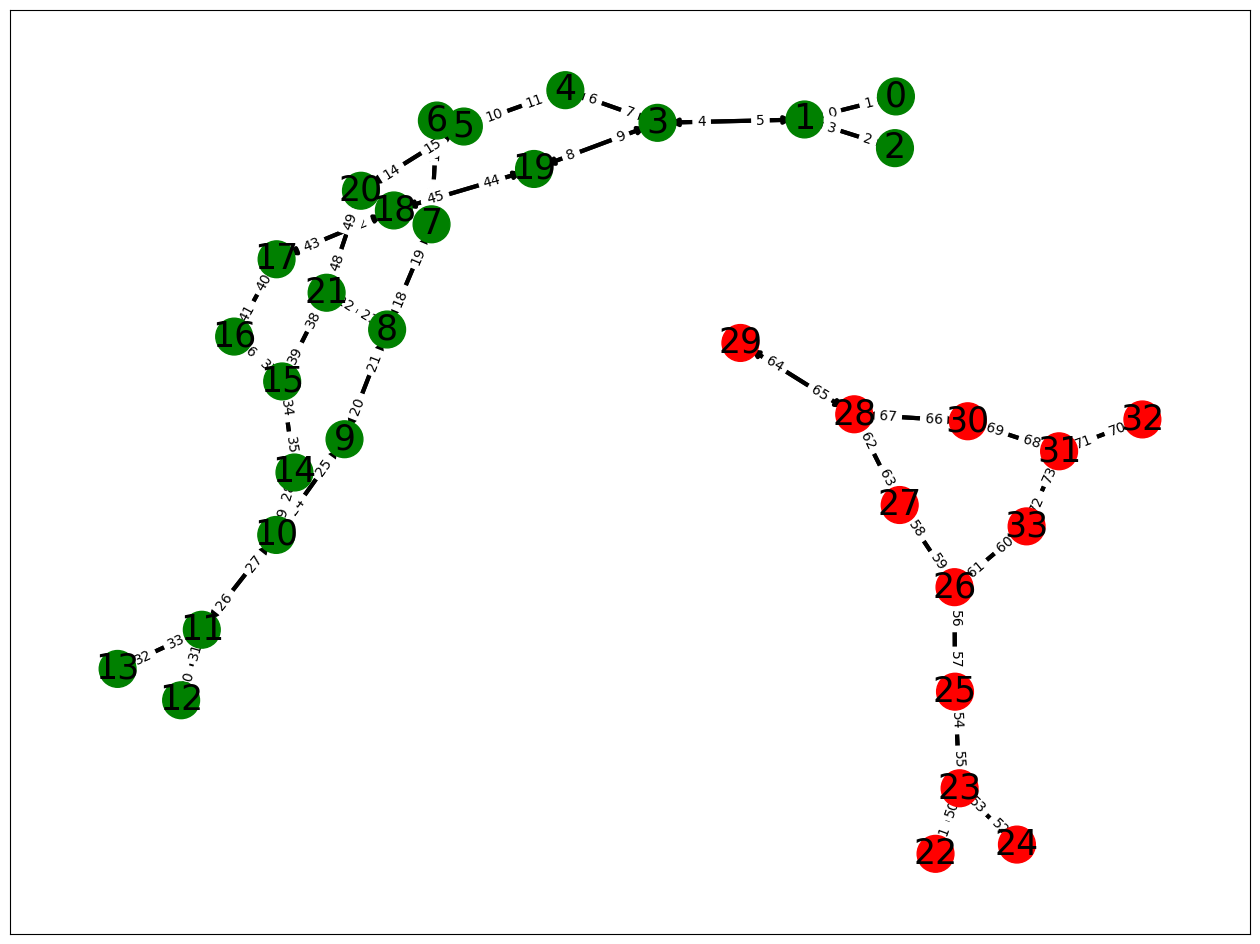

In [135]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
# 创建一个空的无向图
G = nx.DiGraph()

for i in range(w_atoms.shape[0]):
    G.add_node(i, label=w_atoms[i])

for i in range(edge_index.size(1)):
    G.add_edge(edge_index[0][i].item(),edge_index[1][i].item(),color= "black" if w_bonds[i].item() == 1.0 else "grey",label=str(i))
# G = to_networkx(data)
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')
# edge_labels = {(u, v): i for i, (u, v) in enumerate(G.edges(), 1)}
node_colors = ["red" if G.nodes[node]['label'] == 0.25 else "green"  for node in G.nodes]
edge_colors = [G.edges[edge]['color'] for edge in G.edges]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=3, edge_color=[G[u][v]["color"] for u, v in G.edges()], arrows=True)
# nx.draw_networkx_nodes(G, pos, node_size=700)
# nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=3, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=25, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, edge_labels,font_size=10, font_color='black', label_pos=0.3)

plt.show()

In [30]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def calculate_dihedral(mol, atom_indices):
    """
    Calculate dihedral angle given a molecule and a list of atom indices.
    """
    conf = mol.GetConformer()
    return AllChem.GetDihedralDeg(conf, *atom_indices)

def dihedral_angle_matrix(mol):
    """
    Generate the dihedral angle matrix for a molecule.
    """
    num_atoms = mol.GetNumAtoms()
    dihedral_matrix = np.zeros((num_atoms, num_atoms))

    for i in range(num_atoms - 3):
        for j in range(i + 1, num_atoms - 2):
            for k in range(j + 1, num_atoms - 1):
                for l in range(k + 1, num_atoms):
                    dihedral_angle = calculate_dihedral(mol, [i, j, k, l])
                    dihedral_matrix[i, l] = dihedral_angle
                    dihedral_matrix[l, i] = dihedral_angle

    return dihedral_matrix

# Example usage
smiles = "OB(O)c1cc2ccc3cc(B(O)O)cc4ccc(c1)c2c34.Nc1c(Br)cc2[nH]cnc2c1Br"
mol = Chem.MolFromSmiles(smiles)
# mol = Chem.AddHs(mol)  # 添加氢原子，以获得更准确的二面角信息
AllChem.EmbedMolecule(mol)  # 三维构象生成

# 获取自由度矩阵
dihedral_matrix = dihedral_angle_matrix(mol)
print("Dihedral Angle Matrix:")
print(len(dihedral_matrix))


Dihedral Angle Matrix:
34


[18:18:17] Molecule does not have explicit Hs. Consider calling AddHs()
